In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pysiaf
from selectSIAF import defineApertures, getVertices, computeStcsFootprint
from ipyaladin import Aladin

In [2]:
print('  HST PRD version = {}'.format(pysiaf.HST_PRD_VERSION))
print(' JWST PRD version = {}'.format(pysiaf.JWST_PRD_VERSION))
print('ROMAN PRD version = not implemented')

  HST PRD version = Latest
 JWST PRD version = PRDOPSSOC-065
ROMAN PRD version = not implemented


In [3]:
# define telescope pointing at target

selectedTelescope = 'roman'
selectedAperture = 'WFI'        # Allowed options FOV, WFI, CGI or individual apertures

#selectedTelescope = 'hst'
#selectedAperture = 'WFC3'       #Allowed options FOV, ACS, [COS], [FGS], NICMOS, [STIS], WFC3 or individual apertures

#selectedTelescope = 'jwst'
#selectedAperture = 'NIRSPEC'      # Allow options FGS, MIRI, NIRCAM, NIRSPEC, NIRISS


# M101 
targetRa = 210.80243
targetDec = 54.34875
telescopePositionAngle = 180.0

In [4]:
# Set up telescope/aperture and get SIAF

referenceAperture, apertureNames, telescopeSiaf = defineApertures(selectedTelescope, selectedAperture)

# Get v2,v3 of selected aperture
apertureSiaf = telescopeSiaf.apertures[referenceAperture]
apertureV2Ref = apertureSiaf.V2Ref
apertureV3Ref = apertureSiaf.V3Ref

# Set telescope pointing matrix
attmat = pysiaf.utils.rotations.attitude_matrix(apertureV2Ref, apertureV3Ref, targetRa, targetDec, telescopePositionAngle)


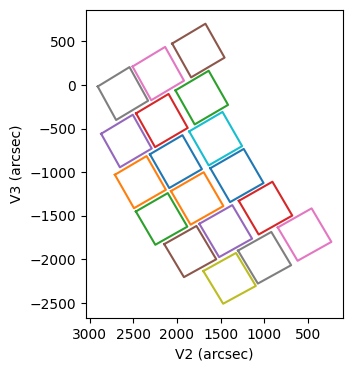

In [5]:
# set up plot of apertures (only works for QUAD,RECT aperture shapes)

plt.figure(figsize=(4, 4), facecolor='w', edgecolor='k')
ax = plt.gca()
for name in apertureNames:
    apertureSiaf = telescopeSiaf.apertures[name]
    apertureSiaf.set_attitude_matrix(attmat)
    apertureSiaf.plot()
ax.set_aspect('equal')
ax.invert_xaxis()
plt.show() 

In [6]:
# Loop through aperture list, transform to sky coordinates, build footprints for passing to Aladin

combinedSregion=''
for name in apertureNames:
    apertureSiaf = telescopeSiaf.apertures[name]
    apertureSiaf.set_attitude_matrix(attmat)
    xVertices, yVertices = getVertices(apertureSiaf)
    skyRa, skyDec = apertureSiaf.idl_to_sky(xVertices, yVertices)
    apertureSregion = computeStcsFootprint(apertureSiaf, skyRa, skyDec)
    combinedSregion+=apertureSregion
print('\n'+combinedSregion)


POLYGON ICRS 210.76871051 54.36620931 210.95136425 54.30467548 211.06014425 54.41313176 210.87675217 54.47420113 POLYGON ICRS 210.55304331 54.43879040 210.73238607 54.37892473 210.84024927 54.48680109 210.65999053 54.54604016 POLYGON ICRS 210.35994448 54.50326787 210.53545201 54.44516199 210.64231833 54.55233714 210.46574339 54.60966931 POLYGON ICRS 210.92483680 54.47018713 211.10873663 54.40885370 211.21856049 54.51641558 211.03423936 54.57723857 POLYGON ICRS 210.70819276 54.54328854 210.88915977 54.48375829 210.99845896 54.59067760 210.81687160 54.64953623 POLYGON ICRS 210.51500799 54.60782552 210.69245661 54.55017021 210.80108615 54.65633215 210.62283975 54.71318651 POLYGON ICRS 211.13915374 54.55458586 211.32434943 54.49304546 211.43451064 54.59934079 211.24925789 54.66037604 POLYGON ICRS 210.92096272 54.62860328 211.10389335 54.56891568 211.21398504 54.67455649 211.03079295 54.73357828 POLYGON ICRS 210.72986796 54.69396265 210.90990186 54.63618641 211.01971590 54.74105999 210.839

In [7]:
aladin = Aladin(height=600, fov=1.0, survey="P/DSS2/color", target=str(targetRa)+' '+str(targetDec))
aladin

Aladin(fov=1.0, height=600.0, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overla…

In [8]:
aladin.add_overlay_from_stcs(combinedSregion,{"color":"green"})